# 3rd Level Model Structure: Initialize Procedure (20+ stages)

In [1]:
# system imports
import sys
import os
import datetime
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../..'))

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import ipywidgets as widgets
from IPython.display import display, clear_output

import pickle
import dill
from copy import deepcopy

In [3]:
# pyomo imports
from pyomo import environ as pe
from global_sets.component import m

from stages.reactive_stage import reactive_stage_rule
from stages.condenser_stage import condenser_stage_rule
from stages.reboiler_stage import reboiler_stage_rule

from utility.display_utility import trans_product_mole, trans_product_mass, beautify, beautify_reactive, HiddenLogs, plot_distribution
from utility.model_utility import add_dual, update_dual, delete_dual, check_DOF, check_violate_constraint
from utility.data_utility import cal_cnumber

In [4]:
model = pe.ConcreteModel(name='reactive_distillation')

In [80]:
logname = datetime.datetime.now().strftime('%Y%m%d_%Hh%Mm%Ss')
log_text_dir = './log/text/'+logname+'.dat'
log_figure_dir = './log/figure/'+logname+'.pdf'

# Model Input

In [154]:
tray_number = 10
non_reactive_flag = [1,2,3,4,10]
# non_reactive_flag = []
side_draw_flag = {4:0.2,7:0.7}
# default temperature is 
temperature_flag = {6:240,7:240,8:245,9:250}
rr_ratio = 0.05

# Global Set

In [7]:
model.TRAY = pe.RangeSet(1,tray_number)
model.TRAY_nonreactive = pe.Set(initialize=non_reactive_flag)
model.TRAY_reactive = model.TRAY - model.TRAY_nonreactive

# Construct reactive stages and Initialization separately

In [8]:
model.reactive = pe.Block(model.TRAY,rule=reactive_stage_rule)
add_dual(pe,model)

> Importing Reactive Stage......
> Adding the following local variable:
------------------------------------
| reactive[1].x_
| reactive[1].y_
| reactive[1].x
| reactive[1].y
| reactive[1].z
| reactive[1].L
| reactive[1].V
| reactive[1].F
| reactive[1].H_L_
| reactive[1].H_V_
| reactive[1].H_L
| reactive[1].H_V
| reactive[1].H_F
| reactive[1].T
| reactive[1].T_F
| reactive[1].P
| reactive[1].f_V
| reactive[1].f_L
| reactive[1].cat
| reactive[1].Q_main
| reactive[1].r_total_comp
| reactive[1].PR_L
| reactive[1].PR_V
------------------------------------

> Importing Kinetics Blocks......
> Adding the following local variable:
--------------------------------------------------
| reactive[1].kinetics_block.k_FT
| reactive[1].kinetics_block.r_FT_total
| reactive[1].kinetics_block.g0_FT
| reactive[1].kinetics_block.alpha
| reactive[1].kinetics_block.r_FT_cnum
| reactive[1].kinetics_block.r_FT_comp
| reactive[1].kinetics_block.k_WGS
| reactive[1].kinetics_block.Ke_WGS
| reactive[1].kinetics_b

> Importing MPCC_P_pf Blocks......
> Adding the following local variable:
--------------------------------------------------
| reactive[4].MPCC.s_L
| reactive[4].MPCC.s_V
| reactive[4].MPCC.pf
| reactive[4].MPCC.rho
--------------------------------------------------
> Spliting pressure used in VLE

> Importing Reactive Stage......
> Adding the following local variable:
------------------------------------
| reactive[5].x_
| reactive[5].y_
| reactive[5].x
| reactive[5].y
| reactive[5].z
| reactive[5].L
| reactive[5].V
| reactive[5].F
| reactive[5].H_L_
| reactive[5].H_V_
| reactive[5].H_L
| reactive[5].H_V
| reactive[5].H_F
| reactive[5].T
| reactive[5].T_F
| reactive[5].P
| reactive[5].f_V
| reactive[5].f_L
| reactive[5].cat
| reactive[5].Q_main
| reactive[5].r_total_comp
| reactive[5].PR_L
| reactive[5].PR_V
------------------------------------

> Importing Kinetics Blocks......
> Adding the following local variable:
--------------------------------------------------
| reactive[5].kin

> Importing MPCC_P_pf Blocks......
> Adding the following local variable:
--------------------------------------------------
| reactive[8].MPCC.s_L
| reactive[8].MPCC.s_V
| reactive[8].MPCC.pf
| reactive[8].MPCC.rho
--------------------------------------------------
> Spliting pressure used in VLE

> Importing Reactive Stage......
> Adding the following local variable:
------------------------------------
| reactive[9].x_
| reactive[9].y_
| reactive[9].x
| reactive[9].y
| reactive[9].z
| reactive[9].L
| reactive[9].V
| reactive[9].F
| reactive[9].H_L_
| reactive[9].H_V_
| reactive[9].H_L
| reactive[9].H_V
| reactive[9].H_F
| reactive[9].T
| reactive[9].T_F
| reactive[9].P
| reactive[9].f_V
| reactive[9].f_L
| reactive[9].cat
| reactive[9].Q_main
| reactive[9].r_total_comp
| reactive[9].PR_L
| reactive[9].PR_V
------------------------------------

> Importing Kinetics Blocks......
> Adding the following local variable:
--------------------------------------------------
| reactive[9].kin

In [9]:
# in/out variable
for j in model.reactive:
    model.reactive[j].x_.fix(0)
    model.reactive[j].y_.fix(0)
    model.reactive[j].L['in'].fix(0)
    model.reactive[j].V['in'].fix(0)
    model.reactive[j].H_L_.fix(0)
    model.reactive[j].H_V_.fix(0)

# operating parameters
for j in model.reactive:
    model.reactive[j].cat.fix(3000)
    model.reactive[j].P.fix(20)
    model.reactive[j].VLE_block.n_ave.fix(20)
    
    model.reactive[j].F.fix(1)
    model.reactive[j].T_F.fix(200+273.15)
    model.reactive[j].z['CO'].fix(1/(1+2)-0/2)
    model.reactive[j].z['H2'].fix(2/(1+2)-0/2)
    model.reactive[j].z['C30H62'].fix(0)
    
    model.reactive[j].PR_L.fix(1)
    model.reactive[j].PR_V.fix(1)
    
    # model.reactive[j].Q_main.fix(0)
    model.reactive[j].T.setub(220+273.15)
    model.reactive[j].T.setlb(200+273.15)

In [10]:
check_DOF(pe,model)

Active Equality Constraints:	 11840
Active Inequality Constraints:	 10
Active Variables:		 13600
Fixed Variables:		 1720
DOF:				 40


In [11]:
model.obj = pe.Objective(expr = sum(model.reactive[j].T - model.reactive[j].MPCC.pf \
                                    for j in model.reactive),sense=pe.maximize)

In [12]:
opt = pe.SolverFactory('ipopt')

opt.options['print_user_options'] = 'yes'
opt.options['linear_solver'] = 'ma86'

opt.options['linear_system_scaling '] = 'mc19'
opt.options['linear_scaling_on_demand '] = 'no'

# opt.options['warm_start_init_point'] = 'yes'
# opt.options['warm_start_bound_push'] = 1e-20
# opt.options['warm_start_mult_bound_push'] = 1e-20
# opt.options['mu_init'] = 1e-6

# opt.options['halt_on_ampl_error'] = 'yes'

opt.options['max_iter'] = 7000

In [13]:
%%time

results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.8: print_user_options=yes
linear_solver=ma86
linear_system_scaling =mc19
linear_scaling_on_demand =no
max_iter=7000


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 7000                  yes
                      print_user_options = yes                   yes

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.8, running with

CPU times: user 1.48 s, sys: 87.2 ms, total: 1.57 s
Wall time: 13.1 s


In [14]:
print('First Solve, disconnected reactive stages')
print('-'*108)
beautify_reactive(pe,model)

First Solve, disconnected reactive stages
------------------------------------------------------------------------------------------------------------
stages			T	Q		V_out	L_out	L_Prod		P_VLE		r_FT	Conversion
React-ive[1]		220.0	-43.2		0.0000	0.0000	0.0064		20.000		0.2660	0.815
React-ive[2]		220.0	-43.2		0.0000	0.0000	0.0064		20.000		0.2660	0.815
React-ive[3]		220.0	-43.2		0.0000	0.0000	0.0064		20.000		0.2660	0.815
React-ive[4]		220.0	-43.2		0.0000	0.0000	0.0064		20.000		0.2660	0.815
React-ive[5]		220.0	-43.2		0.0000	0.0000	0.0064		20.000		0.2660	0.815
React-ive[6]		220.0	-43.2		0.0000	0.0000	0.0064		20.000		0.2660	0.815
React-ive[7]		220.0	-43.2		0.0000	0.0000	0.0064		20.000		0.2660	0.815
React-ive[8]		220.0	-43.2		0.0000	0.0000	0.0064		20.000		0.2660	0.815
React-ive[9]		220.0	-43.2		0.0000	0.0000	0.0064		20.000		0.2660	0.815
React-ive[10]		220.0	-43.2		0.0000	0.0000	0.0064		20.000		0.2660	0.815


# Connect reactive stages and Initialize connectively

### Vapor Between Reactive Stages

In [15]:
def V_between_rule(model,j):
    if j == model.TRAY.last(): return pe.Constraint.Skip
    return model.reactive[j].V['in'] == model.reactive[j+1].V['out']
model.V_between_con = pe.Constraint(model.TRAY,rule=V_between_rule)

def Vy_between_rule(model,j,i):
    if j == model.TRAY.last(): return pe.Constraint.Skip
    return model.reactive[j].y_['in',i] == model.reactive[j+1].y[i]
model.Vy_between_con = pe.Constraint(model.TRAY,m.COMP_TOTAL,rule=Vy_between_rule)

def Vh_between_rule(model,j):
    if j == model.TRAY.last(): return pe.Constraint.Skip
    return model.reactive[j].H_V_['in'] == model.reactive[j+1].H_V
model.Vh_between_con = pe.Constraint(model.TRAY,rule=Vh_between_rule)

### Liquid Between Reactive Stages

In [16]:
def L_between_rule(model,j):
    if j == model.TRAY.last(): return pe.Constraint.Skip
    return model.reactive[j+1].L['in'] == model.reactive[j].L['out']
model.L_between_con = pe.Constraint(model.TRAY,rule=L_between_rule)

def Lx_between_rule(model,j,i):
    if j == model.TRAY.last(): return pe.Constraint.Skip
    return model.reactive[j+1].x_['in',i] == model.reactive[j].x[i]
model.Ly_between_con = pe.Constraint(model.TRAY,m.COMP_TOTAL,rule=Lx_between_rule)

def Lh_between_rule(model,j):
    if j == model.TRAY.last(): return pe.Constraint.Skip
    return model.reactive[j+1].H_L_['in'] == model.reactive[j].H_L
model.Lh_between_con = pe.Constraint(model.TRAY,rule=Lh_between_rule)

### Unlock liquid and vapor in-flow

In [17]:
for j in model.reactive:
    if j != model.TRAY.first():
        model.reactive[j].x_.unfix()
        model.reactive[j].H_L_.unfix()
        model.reactive[j].L['in'].unfix()
    if j != model.TRAY.last():
        model.reactive[j].y_.unfix()
        model.reactive[j].V['in'].unfix()
        model.reactive[j].H_V_.unfix()

In [18]:
check_DOF(pe,model)

Active Equality Constraints:	 13298
Active Inequality Constraints:	 10
Active Variables:		 13600
Fixed Variables:		 262
DOF:				 40


In [19]:
opt.options['warm_start_init_point'] = 'yes'
opt.options['warm_start_bound_push'] = 1e-20
opt.options['warm_start_mult_bound_push'] = 1e-20
opt.options['mu_init'] = 1e-6

results = opt.solve(model,tee=False)
update_dual(pe,model)

### Iteratively reduce stage product draw ratio

\begin{align}
PR_L &= \frac{\text{Liquid Side Draw}}{\text{Total Liquid Product}}
\newline
\newline
PR_V &= \frac{\text{Vapor Side Draw}}{\text{Total Vapor Product}}
\end{align}

In [20]:
%%time

PR_range = np.linspace(1,0,11)
for r in PR_range:
    for j in model.reactive:
        model.reactive[j].PR_L.fix(r)
        model.reactive[j].PR_V.fix(r)
          
    results = opt.solve(model,tee=False)
    update_dual(pe,model)
    print('\n>','Working on PR ratio = {:.2f}'.format(r))
    print('-'*108)
    beautify_reactive(pe,model)


> Working on PR ratio = 1.00
------------------------------------------------------------------------------------------------------------
stages			T	Q		V_out	L_out	L_Prod		P_VLE		r_FT	Conversion
React-ive[1]		220.0	-43.2		0.0000	0.0000	0.0064		20.000		0.2660	0.815
React-ive[2]		220.0	-43.2		0.0000	0.0000	0.0064		20.000		0.2660	0.815
React-ive[3]		220.0	-43.2		0.0000	0.0000	0.0064		20.000		0.2660	0.815
React-ive[4]		220.0	-43.2		0.0000	0.0000	0.0064		20.000		0.2660	0.815
React-ive[5]		220.0	-43.2		0.0000	0.0000	0.0064		20.000		0.2660	0.815
React-ive[6]		220.0	-43.2		0.0000	0.0000	0.0064		20.000		0.2660	0.815
React-ive[7]		220.0	-43.2		0.0000	0.0000	0.0064		20.000		0.2660	0.815
React-ive[8]		220.0	-43.2		0.0000	0.0000	0.0064		20.000		0.2660	0.815
React-ive[9]		220.0	-43.2		0.0000	0.0000	0.0064		20.000		0.2660	0.815
React-ive[10]		220.0	-43.2		0.0000	0.0000	0.0064		20.000		0.2660	0.815

> Working on PR ratio = 0.90
-------------------------------------------------------------------------


> Working on PR ratio = 0.00
------------------------------------------------------------------------------------------------------------
stages			T	Q		V_out	L_out	L_Prod		P_VLE		r_FT	Conversion
React-ive[1]		220.0	-43.2		4.7761	0.0064	0.0000		20.000		0.2660	0.306
React-ive[2]		220.0	-43.2		4.2985	0.0128	0.0000		20.000		0.2660	0.328
React-ive[3]		220.0	-43.2		3.8209	0.0192	0.0000		20.000		0.2660	0.355
React-ive[4]		220.0	-43.2		3.3432	0.0257	0.0000		20.000		0.2660	0.386
React-ive[5]		220.0	-43.2		2.8656	0.0321	0.0000		20.000		0.2660	0.423
React-ive[6]		220.0	-43.2		2.3880	0.0385	0.0000		20.000		0.2660	0.468
React-ive[7]		220.0	-43.2		1.9104	0.0449	0.0000		20.000		0.2660	0.524
React-ive[8]		220.0	-43.2		1.4328	0.0513	0.0000		20.000		0.2660	0.594
React-ive[9]		220.0	-43.2		0.9552	0.0578	0.0000		20.000		0.2660	0.687
React-ive[10]		220.0	-43.2		0.4776	0.0642	0.0000		20.000		0.2660	0.814
CPU times: user 17.6 s, sys: 360 ms, total: 18 s
Wall time: 49.8 s


# Adjusting to non-reactive stages

In [21]:
%%time

for j in model.TRAY_nonreactive:
    
    model.reactive[j].T.unfix()
    model.reactive[j].Q_main.fix(0)
    model.reactive[j].cat.fix(0)
    model.reactive[j].F.fix(0)
    
#     model.del_component(model.obj)
#     model.obj = pe.Objective(expr = sum(model.reactive[j].T - model.reactive[j].MPCC.pf for j in model.TRAY_reactive)\
#                              + sum(- model.reactive[j].MPCC.pf for j in model.TRAY_nonreactive),sense=pe.maximize)
    
    results = opt.solve(model,tee=False)
    update_dual(pe,model)
    
    print('\n>','Working to remove catalyst and feed from stage {}, unfixing temperature, changing to adiabatic:'.format(j))
    print('-'*108)
    beautify_reactive(pe,model)


> Working to remove catalyst and feed from stage 1, unfixing temperature, changing to adiabatic:
------------------------------------------------------------------------------------------------------------
stages			T	Q		V_out	L_out	L_Prod		P_VLE		r_FT	Conversion
NON-react[1]		220.0	0.000		4.2985	0.0000	0.0000		20.000		0.0000	0.000
React-ive[2]		220.0	-43.2		4.2985	0.0064	0.0000		20.000		0.2660	0.328
React-ive[3]		220.0	-43.2		3.8209	0.0128	0.0000		20.000		0.2660	0.355
React-ive[4]		220.0	-43.2		3.3432	0.0192	0.0000		20.000		0.2660	0.386
React-ive[5]		220.0	-43.2		2.8656	0.0257	0.0000		20.000		0.2660	0.423
React-ive[6]		220.0	-43.2		2.3880	0.0321	0.0000		20.000		0.2660	0.468
React-ive[7]		220.0	-43.2		1.9104	0.0385	0.0000		20.000		0.2660	0.524
React-ive[8]		220.0	-43.2		1.4328	0.0449	0.0000		20.000		0.2660	0.594
React-ive[9]		220.0	-43.2		0.9552	0.0513	0.0000		20.000		0.2660	0.687
React-ive[10]		220.0	-43.2		0.4776	0.0578	0.0000		20.000		0.2660	0.814

> Working to remove catalyst and f

# Construct a single condenser and Initialize

### Deactivate the reactive part first

In [22]:
for i in model.block_data_objects():
    if i.name != 'reactive_distillation':
        i.deactivate()
for i in model.component_objects(pe.Constraint, active=True):
    i.deactivate()
check_DOF(pe,model)

Active Equality Constraints:	 0
Active Inequality Constraints:	 0
Active Variables:		 0
Fixed Variables:		 0
DOF:				 0


In [23]:
model.condenser = pe.Block(rule=condenser_stage_rule)

| Importing Condenser Stage......
| Adding the following local variable:
------------------------------------
| condenser.T
| condenser.T_F
| condenser.P
| condenser.Q_main
| condenser.x_
| condenser.y_
| condenser.x
| condenser.y
| condenser.z
| condenser.L
| condenser.W
| condenser.V
| condenser.F
| condenser.H_L_
| condenser.H_V_
| condenser.H_L
| condenser.H_V
| condenser.H_F
| condenser.f_V
| condenser.f_L
| condenser.PR_L
------------------------------------

> Importing Energy Blocks......
> Adding the following local variable:
--------------------------------------------------
| condenser.energy_block.dH_F
| condenser.energy_block.dH_V
| condenser.energy_block.dH_L
| condenser.energy_block.dH_vap
--------------------------------------------------

> Importing VLE Blocks......
> Adding the following local variable:
--------------------------------------------------
| condenser.VLE_block.n_ave
| condenser.VLE_block.n_ave_cal
| condenser.VLE_block.Hen
| condenser.VLE_block.Hen0
| 

### Use the reactive sections vapor output as input to condenser

In [24]:
# in/out variables
model.condenser.x_.fix(0)
for i in m.COMP_TOTAL:
    model.condenser.y_['in',i].fix(model.reactive[model.TRAY.first()].y[i].value)
model.condenser.V['in'].fix(model.reactive[model.TRAY.first()].V['out'].value)
model.condenser.L['in'].fix(0)
model.condenser.V['P'].fix(0)
model.condenser.H_L_.fix(0)
model.condenser.H_V_.fix(model.reactive[model.TRAY.first()].H_V.value)

# operating parameters
model.condenser.P.fix(19)
model.condenser.T_F.fix(200+273.15)
model.condenser.F.fix(0)
model.condenser.z.fix(0)
model.condenser.VLE_block.n_ave.fix(4)
model.condenser.PR_L.fix(1)

model.condenser.T.setub(30+273.15)

In [25]:
model.del_component(model.obj)
model.obj = pe.Objective(expr = model.condenser.T, sense = pe.maximize)

delete_dual(pe,model)
add_dual(pe,model)

Created the follow pyomo suffixes:
ipopt_zL_out, ipopt_zU_out, ipopt_zL_in, ipopt_zU_in, dual


In [26]:
check_DOF(pe,model)

Active Equality Constraints:	 958
Active Inequality Constraints:	 0
Active Variables:		 1130
Fixed Variables:		 171
DOF:				 1


In [27]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.8: print_user_options=yes
linear_solver=ma86
linear_system_scaling =mc19
linear_scaling_on_demand =no
max_iter=7000
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 7000                  yes
                                 mu_init = 1e-06                 yes
                      print_user_options = yes                   yes
                   warm_start_bound_push = 1e-20                 yes
                   warm_start_init_point = yes                   yes
              warm_start_mult_bound_push = 1e-20                 yes

****************************************************

  75r-2.9315000e+02 3.60e-01 1.00e+03  -0.4 0.00e+00    -  0.00e+00 5.03e-08R  2
  76r-2.9384415e+02 3.69e-01 1.00e+03  -0.4 7.90e+06    -  2.48e-06 3.25e-06f  3
  77r-2.9384399e+02 3.69e-01 1.03e+03  -0.4 8.94e+02    -  1.33e-02 3.14e-05h  1
  78r-2.9376088e+02 1.19e-01 5.43e+03  -0.4 7.77e+02    -  2.87e-01 1.84e-02f  1
  79 -2.9460486e+02 8.94e-02 4.93e+00  -6.0 3.62e+01    -  5.46e-01 8.67e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 -2.9460518e+02 8.94e-02 2.63e+05  -6.0 8.97e+01    -  4.70e-01 1.34e-04h  1
  81 -2.9458801e+02 5.32e-04 2.97e+05  -6.0 8.92e-01    -  9.94e-01 9.94e-01h  1
  82 -2.9599956e+02 2.33e-01 1.10e+06  -6.0 2.22e+03    -  2.42e-02 2.38e-02f  1
  83 -3.0315000e+02 6.40e+00 1.17e+08  -6.0 2.19e+03    -  5.64e-02 1.23e-01f  1
  84 -3.0315000e+02 6.40e+00 3.28e+08  -6.0 2.23e+03    -  2.53e-02 6.34e-08h  2
  85 -3.0315000e+02 6.11e+00 2.71e+08  -6.0 6.40e+00    -  2.27e-07 4.54e-02h  1
  86 -3.0314998e+02 2.99e-02

# Construct a single reboiler and Initialize

### Deactivate the condenser part first

In [28]:
model.condenser.deactivate()
check_DOF(pe,model)

Active Equality Constraints:	 0
Active Inequality Constraints:	 0
Active Variables:		 0
Fixed Variables:		 0
DOF:				 0


In [29]:
model.reboiler = pe.Block(rule=reboiler_stage_rule)

> Importing Non Reactive Stage......
> Adding the following local variable:
------------------------------------
| reboiler.T_F
| reboiler.P
| reboiler.Q_main
| reboiler.x_
| reboiler.y_
| reboiler.x
| reboiler.y
| reboiler.z
| reboiler.L
| reboiler.V
| reboiler.F
| reboiler.H_L_
| reboiler.H_V_
| reboiler.H_L
| reboiler.H_V
| reboiler.T
| reboiler.H_F
| reboiler.f_V
| reboiler.f_L
------------------------------------

> Importing Energy Blocks......
> Adding the following local variable:
--------------------------------------------------
| reboiler.energy_block.dH_F
| reboiler.energy_block.dH_V
| reboiler.energy_block.dH_L
| reboiler.energy_block.dH_vap
--------------------------------------------------

> Importing VLE Blocks......
> Adding the following local variable:
--------------------------------------------------
| reboiler.VLE_block.P_VLE
| reboiler.VLE_block.n_ave
| reboiler.VLE_block.n_ave_cal
| reboiler.VLE_block.Hen
| reboiler.VLE_block.Hen0
| reboiler.VLE_block.gamma
| r

### Use the reactive sections liquid output as input to reboiler

In [30]:
# in/out variables
model.reboiler.y_.fix(0)
for i in m.COMP_TOTAL:
    model.reboiler.x_['in',i].fix(model.reactive[model.TRAY.last()].x[i].value)
model.reboiler.L['in'].fix(model.reactive[model.TRAY.last()].L['out'].value)
model.reboiler.V['in'].fix(0)
model.reboiler.L['P'].fix(0)
model.reboiler.V['P'].fix(0)
model.reboiler.H_L_.fix(model.reactive[model.TRAY.last()].H_L.value)
model.reboiler.H_V_.fix(0)

# operating parameters
model.reboiler.P.fix(20)
model.reboiler.T_F.fix(200+273.15)
model.reboiler.F.fix(0)
model.reboiler.z.fix(0)
model.reboiler.VLE_block.n_ave.fix(20)

model.reboiler.T.setub(model.reactive[model.TRAY.last()].T.value)

In [31]:
model.del_component(model.obj)
model.obj = pe.Objective(expr = model.reboiler.T - model.reboiler.MPCC.pf, sense = pe.maximize)

delete_dual(pe,model)
add_dual(pe,model)

Created the follow pyomo suffixes:
ipopt_zL_out, ipopt_zU_out, ipopt_zL_in, ipopt_zU_in, dual


In [32]:
check_DOF(pe,model)

Active Equality Constraints:	 957
Active Inequality Constraints:	 1
Active Variables:		 1132
Fixed Variables:		 171
DOF:				 4


In [33]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.8: print_user_options=yes
linear_solver=ma86
linear_system_scaling =mc19
linear_scaling_on_demand =no
max_iter=7000
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 7000                  yes
                                 mu_init = 1e-06                 yes
                      print_user_options = yes                   yes
                   warm_start_bound_push = 1e-20                 yes
                   warm_start_init_point = yes                   yes
              warm_start_mult_bound_push = 1e-20                 yes

****************************************************

  75 -4.9314593e+02 7.21e-02 3.70e+03  -6.0 3.12e+00    -  1.00e+00 5.77e-01h  1
  76 -4.9315000e+02 1.15e-01 6.16e+02  -6.0 1.08e+01    -  1.00e+00 9.83e-01h  1
  77 -4.9315000e+02 4.45e-02 5.57e+01  -6.0 7.63e+00    -  1.00e+00 1.00e+00h  1
  78 -4.9315000e+02 1.46e-02 6.46e+00  -6.0 3.62e+00    -  1.00e+00 8.54e-01h  1
  79 -4.9315000e+02 3.96e-03 1.53e-01  -6.0 2.16e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 -4.9315000e+02 1.31e-03 1.63e-02  -6.0 1.25e+00    -  1.00e+00 1.00e+00h  1
  81 -4.9315000e+02 1.82e-04 3.20e-02  -6.0 2.07e-01    -  1.00e+00 8.83e-01h  1
  82 -4.9315000e+02 1.54e-04 3.80e-02  -6.0 4.26e-01    -  1.00e+00 1.00e+00f  1
  83 -4.9315000e+02 3.01e-05 7.09e-03  -6.0 1.89e-01    -  1.00e+00 1.00e+00h  1
  84 -4.9315000e+02 8.76e-07 2.02e-04  -6.0 3.22e-02    -  1.00e+00 1.00e+00h  1
  85 -4.9315000e+02 1.03e-09 1.52e-07  -6.0 1.11e-03    -  1.00e+00 1.00e+00h  1
  86 -4.9315000e+02 6.13e-05

# Initialization is complete

In [34]:
beautify(pe,model)

Here comes the result:
------------------------------------------------------------------------------------------------------------
stages			T	Q		V_out	L_out	L_Prod		W
Condenser		30.00	-67.4		1.2741	0.0000	0.0691		1.0447

stages			T	Q		V_out	L_out	L_Prod		P_VLE		r_FT	Conversion
NON-react[1]		220.0	0.000		2.3880	0.0000	0.0000		20.000		0.0000	0.000
NON-react[2]		220.0	0.000		2.3880	0.0000	0.0000		20.000		0.0000	0.000
NON-react[3]		220.0	0.000		2.3880	0.0000	0.0000		20.000		0.0000	0.000
NON-react[4]		220.0	0.000		2.3880	0.0000	0.0000		20.000		0.0000	0.000
React-ive[5]		220.0	-43.2		2.3880	0.0064	0.0000		20.000		0.2660	0.468
React-ive[6]		220.0	-43.2		1.9104	0.0128	0.0000		20.000		0.2660	0.524
React-ive[7]		220.0	-43.2		1.4328	0.0192	0.0000		20.000		0.2660	0.595
React-ive[8]		220.0	-43.2		0.9552	0.0257	0.0000		20.000		0.2660	0.687
React-ive[9]		220.0	-43.2		0.4776	0.0321	0.0000		20.000		0.2660	0.815
NON-react[10]		220.0	0.000		0.0000	0.0321	0.0000		20.000		0.0000	0.000

stages			T	Q		V_out

# Linking Condenser and Reboiler

### Activate previously disabled constraint and variables

In [35]:
for i in model.block_data_objects():
    if i.name != 'reactive_distillation':
        i.activate()
for i in model.component_objects(pe.Constraint):
    i.activate()

### Condenser Vapor

In [36]:
def V_condenser_rule(model):
    return model.reactive[model.TRAY.first()].V['out'] == model.condenser.V['in']
model.V_condenser_con = pe.Constraint(rule=V_condenser_rule)

def Vy_condenser_rule(model,i):
    return model.reactive[model.TRAY.first()].y[i] == model.condenser.y_['in',i]
model.Vy_condenser_con = pe.Constraint(m.COMP_TOTAL,rule=Vy_condenser_rule)

def Vh_condenser_rule(model):
    return model.reactive[model.TRAY.first()].H_V == model.condenser.H_V_['in']
model.Vh_condenser_con = pe.Constraint(rule=Vh_condenser_rule)

### Condenser Liquid

In [37]:
def L_condenser_rule(model):
    return model.reactive[model.TRAY.first()].L['in'] == model.condenser.L['out']
model.L_condenser_con = pe.Constraint(rule=L_condenser_rule)

def Lx_condenser_rule(model,i):
    return model.reactive[model.TRAY.first()].x_['in',i] == model.condenser.x[i]
model.Lx_condenser_con = pe.Constraint(m.COMP_TOTAL,rule=Lx_condenser_rule)

def Lh_condenser_rule(model):
    return model.reactive[model.TRAY.first()].H_L_['in'] == model.condenser.H_L
model.Lh_condenser_con = pe.Constraint(rule=Lh_condenser_rule)

### Reboiler Vapor

In [38]:
def V_reboiler_rule(model):
    return model.reactive[model.TRAY.last()].V['in'] == model.reboiler.V['out']
model.V_reboiler_con = pe.Constraint(rule=V_reboiler_rule)

def Vy_reboiler_rule(model,i):
    return model.reactive[model.TRAY.last()].y_['in',i] == model.reboiler.y[i]
model.Vy_reboiler_con = pe.Constraint(m.COMP_TOTAL,rule=Vy_reboiler_rule)

def Vh_reboiler_rule(model):
    return model.reactive[model.TRAY.last()].H_V_['in'] == model.reboiler.H_V
model.Vh_reboiler_con = pe.Constraint(rule=Vh_reboiler_rule)

### Reboiler Liquid

In [39]:
def L_reboiler_rule(model):
    return model.reactive[model.TRAY.last()].L['out'] + 1e-6 == model.reboiler.L['in']
model.L_reboiler_con = pe.Constraint(rule=L_reboiler_rule)

def Lx_reboiler_rule(model,i):
    return model.reactive[model.TRAY.last()].x[i] == model.reboiler.x_['in',i]
model.Lx_reboiler_con = pe.Constraint(m.COMP_TOTAL,rule=Lx_reboiler_rule)

def Lh_reboiler_rule(model):
    return model.reactive[model.TRAY.last()].H_L == model.reboiler.H_L_['in']
model.Lh_reboiler_con = pe.Constraint(rule=Lh_reboiler_rule)

In [40]:
model.del_component(model.obj)
model.obj = pe.Objective(expr = sum(model.reactive[j].T - model.reactive[j].MPCC.pf for j in model.TRAY_reactive)\
                        + sum( - model.reactive[j].MPCC.pf for j in model.TRAY_nonreactive) - model.reboiler.MPCC.pf ,sense=pe.maximize)

In [41]:
delete_dual(pe,model)
add_dual(pe,model)

Created the follow pyomo suffixes:
ipopt_zL_out, ipopt_zU_out, ipopt_zL_in, ipopt_zU_in, dual


# Fixing Redundent Stream Variables

### Condenser

In [42]:
# in/out variables
model.condenser.x_.fix(0)
for i in m.COMP_TOTAL:
    model.condenser.y_['in',i].unfix()
model.condenser.V['in'].unfix()
model.condenser.L['in'].fix(0)
model.condenser.V['P'].fix(0)
model.condenser.H_L_.fix(0)
model.condenser.H_V_.unfix()

# operating parameters
model.condenser.P.fix(19)
model.condenser.T_F.fix(200+273.15)
model.condenser.F.fix(0)
model.condenser.z.fix(0)
model.condenser.VLE_block.n_ave.fix(4)
model.condenser.PR_L.fix(1)

model.condenser.T.fix(30+273.15)

### Reboiler

In [43]:
# in/out variables
model.reboiler.y_.fix(0)
for i in m.COMP_TOTAL:
    model.reboiler.x_['in',i].unfix()
model.reboiler.L['in'].unfix()
model.reboiler.V['in'].fix(0)
model.reboiler.L['P'].fix(0)
model.reboiler.V['P'].fix(0)
model.reboiler.H_L_.unfix()
model.reboiler.H_V_.fix(0)

# operating parameters
model.reboiler.P.fix(20)
model.reboiler.T_F.fix(200+273.15)
model.reboiler.F.fix(0)
model.reboiler.z.fix(0)
model.reboiler.VLE_block.n_ave.fix(20)

model.reboiler.T.fix(model.reactive[model.TRAY.last()].T.value)

### Reactive

In [44]:
# unlock reflux and reboiler vapor
for j in model.reactive:
    model.reactive[j].x_.unfix()
    model.reactive[j].H_L_.unfix()
    model.reactive[j].L['in'].unfix()
    model.reactive[j].y_.unfix()
    model.reactive[j].V['in'].unfix()
    model.reactive[j].H_V_.unfix()

for j in model.reactive:
    if j in model.TRAY_reactive:
        model.reactive[j].cat.fix(3000)
        model.reactive[j].P.fix(20)
        model.reactive[j].VLE_block.n_ave.fix(20)

        model.reactive[j].F.fix(1)
        model.reactive[j].T_F.fix(200+273.15)
        model.reactive[j].z['CO'].fix(1/(1+2)-0/2)
        model.reactive[j].z['H2'].fix(2/(1+2)-0/2)
        model.reactive[j].z['C30H62'].fix(0)

        model.reactive[j].PR_L.fix(0)
        model.reactive[j].PR_V.fix(0)

        # model.reactive[j].Q_main.fix(0)
        model.reactive[j].T.setub(220+273.15)
        model.reactive[j].T.setlb(200+273.15)
    
    elif j in model.TRAY_nonreactive:
        model.reactive[j].cat.fix(0)
        model.reactive[j].P.fix(20)
        model.reactive[j].VLE_block.n_ave.fix(20)

        model.reactive[j].F.fix(0)
        model.reactive[j].T_F.fix(200+273.15)
        model.reactive[j].z['CO'].fix(1/(1+2)-0/2)
        model.reactive[j].z['H2'].fix(2/(1+2)-0/2)
        model.reactive[j].z['C30H62'].fix(0)

        model.reactive[j].PR_L.fix(0)
        model.reactive[j].PR_V.fix(0)

        model.reactive[j].Q_main.fix(0)
        model.reactive[j].T.setub(350+273.15)
        model.reactive[j].T.setlb(100+273.15)

# Connected Solve

**DOF:**
* Each Reactive Stage:            4 (T, s_L, s_V, pf)
* Each Non-Reactive Stage:        3 (s_L, s_V, pf)
* Reboiler:                       3 (s_L, s_V, pf)

In [45]:
check_DOF(pe,model)

Active Equality Constraints:	 15537
Active Inequality Constraints:	 11
Active Variables:		 15862
Fixed Variables:		 287
DOF:				 38


In [46]:
%%time

results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.8: print_user_options=yes
linear_solver=ma86
linear_system_scaling =mc19
linear_scaling_on_demand =no
max_iter=7000
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 7000                  yes
                                 mu_init = 1e-06                 yes
                      print_user_options = yes                   yes
                   warm_start_bound_push = 1e-20                 yes
                   warm_start_init_point = yes                   yes
              warm_start_mult_bound_push = 1e-20                 yes

****************************************************

In [47]:
beautify(pe,model)

Here comes the result:
------------------------------------------------------------------------------------------------------------
stages			T	Q		V_out	L_out	L_Prod		W
Condenser		30.00	-67.4		1.2741	0.0000	0.0691		1.0447

stages			T	Q		V_out	L_out	L_Prod		P_VLE		r_FT	Conversion
NON-react[1]		220.0	0.000		2.3880	0.0000	0.0000		20.026		0.0000	0.000
NON-react[2]		220.0	0.000		2.3880	0.0000	0.0000		20.005		0.0000	0.000
NON-react[3]		220.0	0.000		2.3880	0.0000	0.0000		20.005		0.0000	0.000
NON-react[4]		220.0	0.000		2.3880	0.0000	0.0000		20.007		0.0000	0.000
React-ive[5]		220.0	-43.2		2.3880	0.0064	0.0000		20.000		0.2660	0.468
React-ive[6]		220.0	-43.2		1.9104	0.0128	0.0000		20.000		0.2660	0.524
React-ive[7]		220.0	-43.2		1.4328	0.0192	0.0000		20.000		0.2660	0.595
React-ive[8]		220.0	-43.2		0.9552	0.0257	0.0000		20.000		0.2660	0.687
React-ive[9]		220.0	-43.2		0.4776	0.0321	0.0000		20.000		0.2660	0.815
NON-react[10]		219.9	0.000		0.0000	0.0321	0.0000		19.998		0.0000	0.000

stages			T	Q		V_out

# Introducing Reflux (Iteratively or directly)

In [48]:
%%time

PR_range = np.linspace(1,rr_ratio,10)
for r in PR_range:
    model.condenser.PR_L.fix(r)
          
    results = opt.solve(model,tee=False)
    update_dual(pe,model)
    
    print('\n>','Working on PR ratio = {:.2f}'.format(r))
    print('-'*108)
    beautify(pe,model)


> Working on PR ratio = 1.00
------------------------------------------------------------------------------------------------------------
Here comes the result:
------------------------------------------------------------------------------------------------------------
stages			T	Q		V_out	L_out	L_Prod		W
Condenser		30.00	-67.4		1.2741	0.0000	0.0691		1.0447

stages			T	Q		V_out	L_out	L_Prod		P_VLE		r_FT	Conversion
NON-react[1]		220.0	0.000		2.3880	0.0000	0.0000		20.026		0.0000	0.000
NON-react[2]		220.0	0.000		2.3880	0.0000	0.0000		20.005		0.0000	0.000
NON-react[3]		220.0	0.000		2.3880	0.0000	0.0000		20.005		0.0000	0.000
NON-react[4]		220.0	0.000		2.3880	0.0000	0.0000		20.007		0.0000	0.000
React-ive[5]		220.0	-43.2		2.3880	0.0064	0.0000		20.000		0.2660	0.468
React-ive[6]		220.0	-43.2		1.9104	0.0128	0.0000		20.000		0.2660	0.524
React-ive[7]		220.0	-43.2		1.4328	0.0192	0.0000		20.000		0.2660	0.595
React-ive[8]		220.0	-43.2		0.9552	0.0257	0.0000		20.000		0.2660	0.687
React-ive[9]		220.0	-4


> Working on PR ratio = 0.26
------------------------------------------------------------------------------------------------------------
Here comes the result:
------------------------------------------------------------------------------------------------------------
stages			T	Q		V_out	L_out	L_Prod		W
Condenser		30.00	-69.0		1.2891	0.1396	0.0493		1.0383

stages			T	Q		V_out	L_out	L_Prod		P_VLE		r_FT	Conversion
NON-react[1]		170.8	0.000		2.5163	0.1452	0.0000		20.000		0.0000	0.000
NON-react[2]		198.0	0.000		2.5220	0.1310	0.0000		20.000		0.0000	0.000
NON-react[3]		208.8	0.000		2.5077	0.1199	0.0000		20.000		0.0000	0.000
NON-react[4]		214.3	0.000		2.4967	0.1029	0.0000		20.000		0.0000	0.000
React-ive[5]		220.0	-41.3		2.4797	0.0679	0.0000		20.000		0.2645	0.464
React-ive[6]		220.0	-42.3		1.9578	0.0510	0.0000		20.000		0.2651	0.521
React-ive[7]		220.0	-42.7		1.4551	0.0458	0.0000		20.000		0.2655	0.593
React-ive[8]		220.0	-43.0		0.9650	0.0465	0.0000		20.000		0.2657	0.686
React-ive[9]		220.0	-4

# Introducing Reboiler (Iteratively or directly)

In [49]:
%%time

T_range = np.linspace(220+273.15,350+273.15,2)
for t in T_range:
    model.reboiler.T.fix(t)
          
    results = opt.solve(model,tee=False)
    update_dual(pe,model)
    print('\n>','Working on reboiler temperature = {:.2f}'.format(t))
    print('-'*108)
    beautify(pe,model)


> Working on reboiler temperature = 493.15
------------------------------------------------------------------------------------------------------------
Here comes the result:
------------------------------------------------------------------------------------------------------------
stages			T	Q		V_out	L_out	L_Prod		W
Condenser		30.00	-81.1		1.3642	0.4618	0.0243		1.0092

stages			T	Q		V_out	L_out	L_Prod		P_VLE		r_FT	Conversion
NON-react[1]		159.7	0.000		2.8595	0.6579	0.0000		20.000		0.0000	0.000
NON-react[2]		186.4	0.000		3.0556	0.6724	0.0000		20.000		0.0000	0.000
NON-react[3]		201.2	0.000		3.0701	0.6694	0.0000		20.000		0.0000	0.000
NON-react[4]		211.1	0.000		3.0671	0.6439	0.0000		20.000		0.0000	0.000
React-ive[5]		220.0	-33.8		3.0417	0.4026	0.0000		20.000		0.2569	0.438
React-ive[6]		220.0	-37.6		2.2986	0.2260	0.0000		20.000		0.2592	0.501
React-ive[7]		220.0	-39.6		1.6248	0.1224	0.0000		20.000		0.2617	0.579
React-ive[8]		220.0	-41.5		1.0288	0.0806	0.0000		20.000		0.2638	0.679
React-iv

# Introduce Side-draws

In [50]:
for j in side_draw_flag.keys():
    
    r = side_draw_flag[j]
    model.reactive[j].PR_L.fix(r)
          
    results = opt.solve(model,tee=False)
    update_dual(pe,model)
    print('\n>','Working on side draw of {:.1%} on stage {}'.format(r,j))
    print('-'*108)
    beautify(pe,model)


> Working on side draw of 20.0% on stage 4
------------------------------------------------------------------------------------------------------------
Here comes the result:
------------------------------------------------------------------------------------------------------------
stages			T	Q		V_out	L_out	L_Prod		W
Condenser		30.00	-69.8		1.3012	0.3085	0.0162		1.0353

stages			T	Q		V_out	L_out	L_Prod		P_VLE		r_FT	Conversion
NON-react[1]		138.0	0.000		2.6614	0.3892	0.0000		20.000		0.0000	0.000
NON-react[2]		157.6	0.000		2.7420	0.3409	0.0000		20.000		0.0000	0.000
NON-react[3]		174.1	0.000		2.6938	0.2708	0.0000		20.000		0.0000	0.000
NON-react[4]		193.4	0.000		2.6236	0.1414	0.0353		20.000		0.0000	0.000
React-ive[5]		220.0	-38.4		2.5296	0.0454	0.0000		20.000		0.2631	0.462
React-ive[6]		220.0	-42.5		1.9441	0.0318	0.0000		20.000		0.2653	0.522
React-ive[7]		220.0	-43.0		1.4451	0.0325	0.0000		20.000		0.2658	0.593
React-ive[8]		220.0	-43.1		0.9613	0.0366	0.0000		20.000		0.2659	0.686
React-iv

# Fine Tuning Stage Temperature

In [155]:
for j in temperature_flag.keys():
    
    t = temperature_flag[j] + 273.15
    model.reactive[j].T.setub(t)
          
    results = opt.solve(model,tee=False)
    update_dual(pe,model)
    print('\n>','Working on adjusting stage {} temperature to {:.2f}C '.format(j,t-273.15))
    print('-'*108)
    beautify(pe,model)


> Working on adjusting stage 6 temperature to 513.15C 
------------------------------------------------------------------------------------------------------------
Here comes the result:
------------------------------------------------------------------------------------------------------------
stages			T	Q		V_out	L_out	L_Prod		W
Condenser		30.00	-74.0		1.1741	0.3655	0.0192		1.0991

stages			T	Q		V_out	L_out	L_Prod		P_VLE		r_FT	Conversion
NON-react[1]		135.2	0.000		2.6581	0.4589	0.0000		20.000		0.0000	0.000
NON-react[2]		153.4	0.000		2.7515	0.4034	0.0000		20.000		0.0000	0.000
NON-react[3]		170.2	0.000		2.6960	0.3212	0.0000		20.000		0.0000	0.000
NON-react[4]		191.3	0.000		2.6138	0.1705	0.0426		20.000		0.0000	0.000
React-ive[5]		220.0	-37.4		2.5057	0.0817	0.0000		20.000		0.2423	0.477
React-ive[6]		240.0	-45.7		1.8869	0.0285	0.0000		20.000		0.3228	0.643
React-ive[7]		220.0	-43.2		1.4444	0.0080	0.0187		20.000		0.2657	0.594
React-ive[8]		220.0	-43.2		0.9580	0.0132	0.0000		20.000		0.2659	0.

In [115]:
# with open('modelsaved.pickle','wb') as f:
#     dill.dump(model,f)

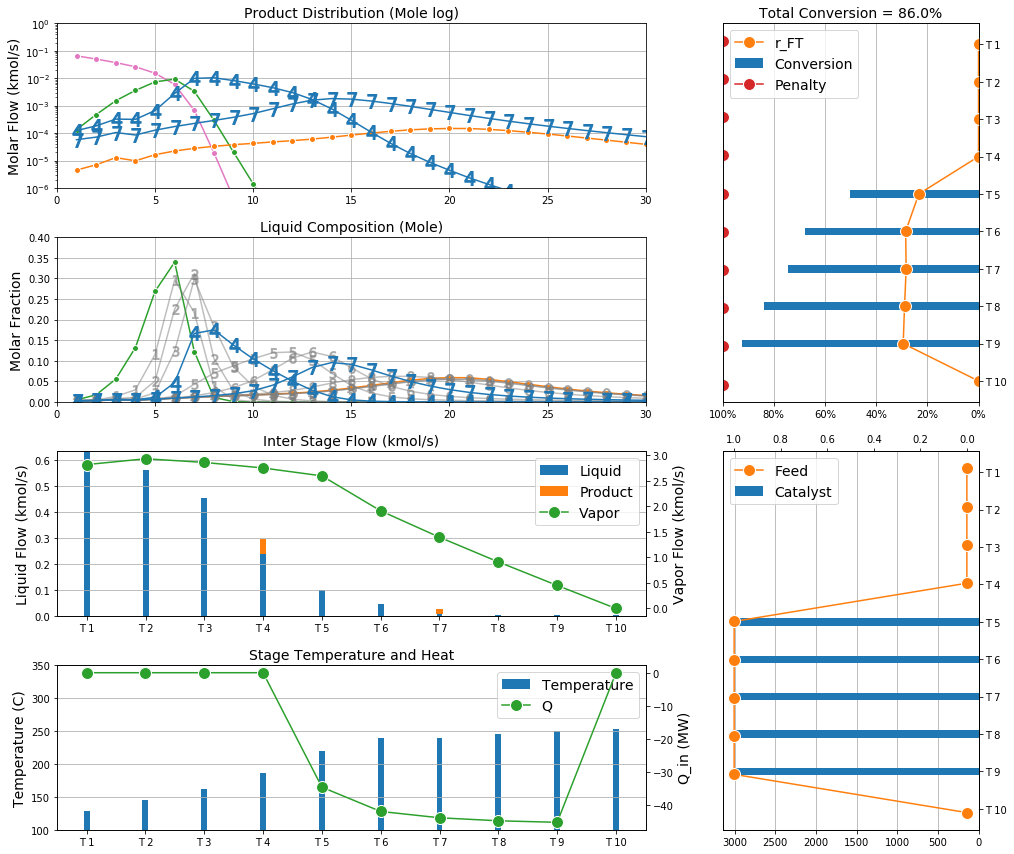

In [156]:
plot_distribution(model)